#### Установщики

!pip install kaggle
from google.colab import files
files.upload()

!pip install ultralytics

from google.colab import drive
drive.mount('/content/drive')

#### Импорт датасета

In [3]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download fareselmenshawii/face-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/fareselmenshawii/face-detection-dataset
License(s): CC0-1.0
 99% 4.41G/4.43G [00:47<00:00, 247MB/s]
100% 4.43G/4.43G [00:47<00:00, 99.9MB/s]


In [8]:
!unzip /content/face-detection-dataset.zip -d /content/dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/labels2/b0a96b76a58c433c.txt  
  inflating: /content/dataset/labels2/b0abd92b73ecb406.txt  
  inflating: /content/dataset/labels2/b0b880a17aeb2905.txt  
  inflating: /content/dataset/labels2/b0b9a9952976e42b.txt  
  inflating: /content/dataset/labels2/b0bfe0f426275870.txt  
  inflating: /content/dataset/labels2/b0c2f74e1fed9b71.txt  
  inflating: /content/dataset/labels2/b0c4491f61005387.txt  
  inflating: /content/dataset/labels2/b0c4ccd19b83f4c6.txt  
  inflating: /content/dataset/labels2/b0c66e943f050df1.txt  
  inflating: /content/dataset/labels2/b0c9eb2a1f9aa986.txt  
  inflating: /content/dataset/labels2/b0cf4af0df03be90.txt  
  inflating: /content/dataset/labels2/b0d51a66b2c3abeb.txt  
  inflating: /content/dataset/labels2/b0d9501aa2380861.txt  
  inflating: /content/dataset/labels2/b0d97c088f04e8b1.txt  
  inflating: /content/dataset/labels2/b0d9c679a092d344.txt  
  inflating: /con

In [9]:
import yaml

data = {
    'train': '/content/dataset/images/train',
    'val': '/content/dataset/images/val',
    'test': '/content/dataset/images/val',  # если нет test, используйте val
    'nc': 1,  # количество классов (замените на ваше)
    'names': ['Human face']  # имена классов (замените на ваши)
}

# Сохраняем файл
with open('/content/data.yaml', 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

# Проверяем содержимое
!cat /content/data.yaml

names:
- Human face
nc: 1
test: /content/dataset/images/val
train: /content/dataset/images/train
val: /content/dataset/images/val


In [40]:
import os
from pathlib import Path

def get_dataset_stats(data_yaml_path):
    # Читаем YAML файл
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    # Получаем пути
    train_path = data_config['train']
    val_path = data_config['val']

    # Считаем количество изображений
    def count_images(folder_path):
        if not os.path.exists(folder_path):
            return 0
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        count = 0
        for ext in image_extensions:
            count += len(list(Path(folder_path).glob(f'*{ext}')))
            count += len(list(Path(folder_path).glob(f'*{ext.upper()}')))
        return count

    train_count = count_images(train_path)
    val_count = count_images(val_path)

    # Считаем количество аннотаций (предполагаем формат YOLO)
    def count_annotations(folder_path):
        if not os.path.exists(folder_path):
            return 0
        annotations_path = folder_path.replace('images', 'labels')
        if os.path.exists(annotations_path):
            return len(list(Path(annotations_path).glob('*.txt')))
        return 0

    train_annotations = count_annotations(train_path)
    val_annotations = count_annotations(val_path)

    return {
        'train_images': train_count,
        'val_images': val_count,
        'train_annotations': train_annotations,
        'val_annotations': val_annotations,
        'classes': data_config['nc'],
        'class_names': data_config['names']
    }

# Использование
stats = get_dataset_stats('/content/data.yaml')
print("Статистика датасета:")
print(f"Обучающие изображения: {stats['train_images']}")
print(f"Валидационные изображения: {stats['val_images']}")
print(f"Обучающие аннотации: {stats['train_annotations']}")
print(f"Валидационные аннотации: {stats['val_annotations']}")
print(f"Количество классов: {stats['classes']}")
print(f"Имена классов: {stats['class_names']}")

Статистика датасета:
Обучающие изображения: 13386
Валидационные изображения: 3347
Обучающие аннотации: 13386
Валидационные аннотации: 3347
Количество классов: 1
Имена классов: ['Human face']


#### Импорт библиотек

In [10]:
from ultralytics import YOLO
import torch
import pandas as pd
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### Импорт модели и обучение

In [11]:
# Место для расчета модели
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [12]:
# Выбор модели
model = YOLO("yolo11m.pt")

In [13]:
# Обучение модели
results = model.train(
    data="/content/data.yaml",
    epochs=5,
    imgsz=640,
    batch=8,
    device=DEVICE
    )

Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

# Дообучение
results = model.train(
    data='/content/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    patience=10,
    lr0=0.001,  # начальная скорость обучения
    lrf=0.01,   # конечная скорость обучения
    weight_decay=0.0005,
    warmup_epochs=3,
    augment=True,  # аугментация
    save=True,
    save_period=10,
    project='yolo11-face-detection',
    name='exp1'
)

In [15]:
# Запишем итоги по эпохами в датафрейм
model_metrics = pd.read_csv('/content/runs/detect/train/results.csv')

In [18]:
model_metrics

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,639.596,1.39206,1.05589,1.25365,0.88124,0.59870,0.69932,0.43267,1.37886,0.99292,1.28363,0.000666,0.000666,0.000666
1,2,1207.620,1.34919,0.95635,1.24054,0.85912,0.72655,0.80519,0.50501,1.30199,0.80705,1.22440,0.001069,0.001069,0.001069
2,3,1774.040,1.28852,0.86696,1.20546,0.86585,0.75140,0.82612,0.52457,1.26619,0.73522,1.19254,0.001208,0.001208,0.001208
3,4,2341.840,1.24078,0.77878,1.16855,0.87070,0.77522,0.84713,0.54482,1.23354,0.67235,1.16916,0.000812,0.000812,0.000812
4,5,2911.000,1.18475,0.69913,1.13332,0.88209,0.80267,0.87249,0.57144,1.17357,0.59922,1.12954,0.000416,0.000416,0.000416


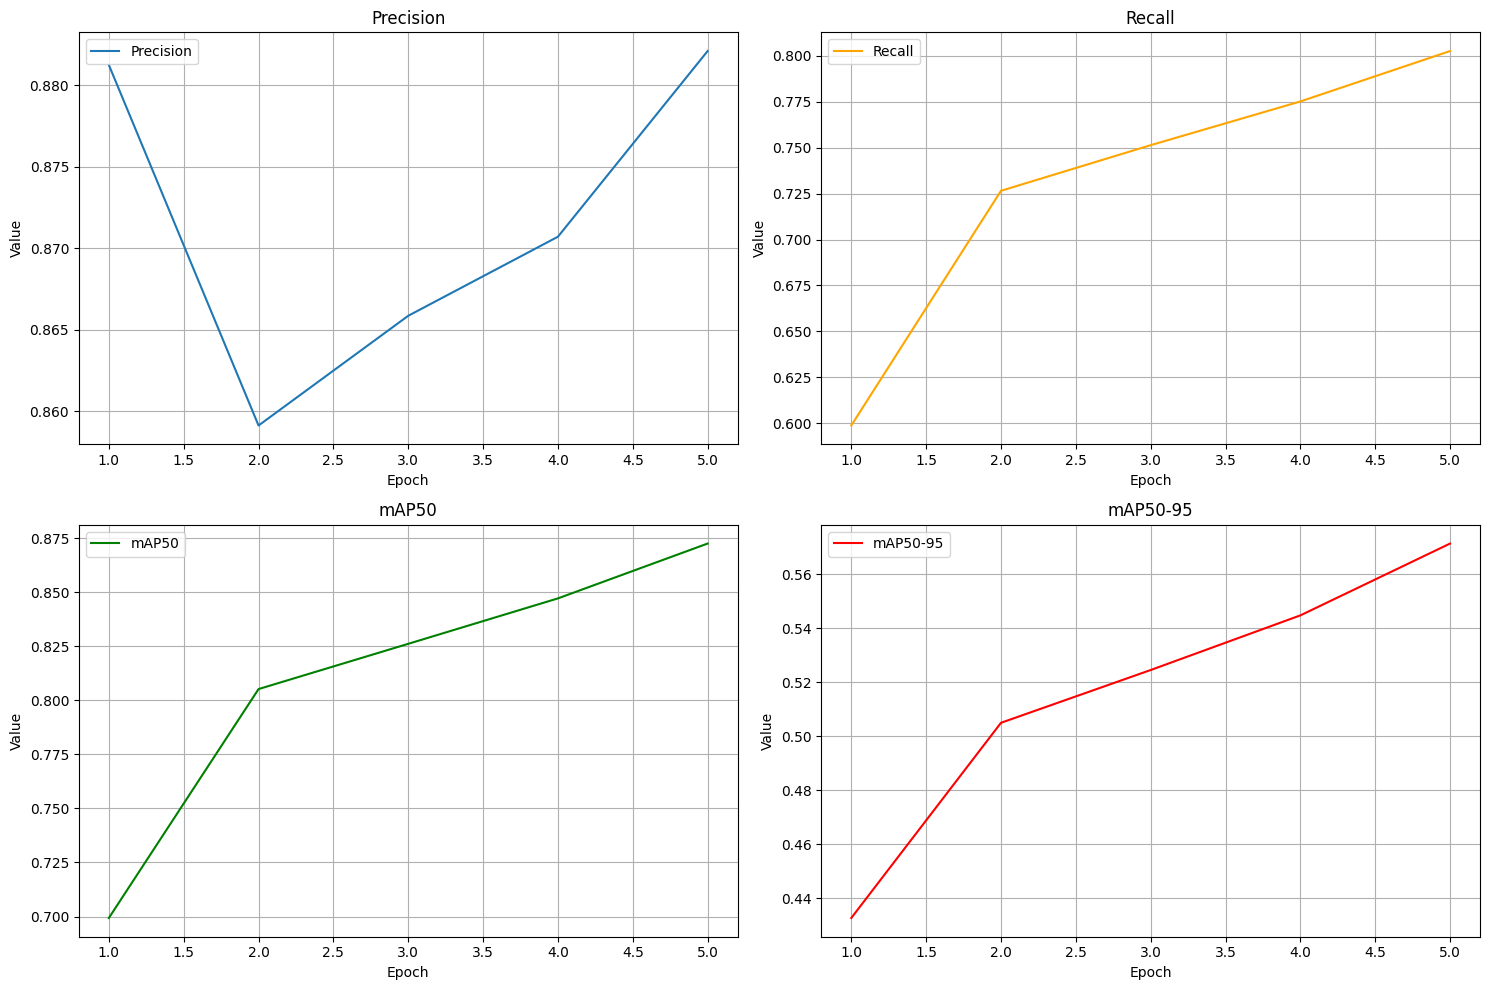

In [16]:
# Графики метрик
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Точность (precision)
axes[0, 0].plot(model_metrics['epoch'], model_metrics['metrics/precision(B)'], label='Precision')
axes[0, 0].set_title('Precision')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Полнота (recall)
axes[0, 1].plot(model_metrics['epoch'], model_metrics['metrics/recall(B)'], label='Recall', color='orange')
axes[0, 1].set_title('Recall')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True)

# mAP50
axes[1, 0].plot(model_metrics['epoch'], model_metrics['metrics/mAP50(B)'], label='mAP50', color='green')
axes[1, 0].set_title('mAP50')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# mAP50-95
axes[1, 1].plot(model_metrics['epoch'], model_metrics['metrics/mAP50-95(B)'], label='mAP50-95', color='red')
axes[1, 1].set_title('mAP50-95')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [24]:
# Сохранение модели
import os
import shutil

# Пути для сохранения
training_folder = '/content/runs/detect/train/'
drive_training_path = '/content/drive/MyDrive/Colab_Notebooks/models/face_detection/v1'
os.makedirs(drive_training_path, exist_ok=True)

# Копируем всю папку
shutil.copytree(training_folder, drive_training_path, dirs_exist_ok=True)
print(f"Полная папка обучения сохранена: {drive_training_path}")

Полная папка обучения сохранена: /content/drive/MyDrive/Colab_Notebooks/models/face_detection/v1


#### Валидация

In [26]:
# Валидация на тестовых данных
val_results = model.val(
    data='/content/data.yaml',
    split='val',  # или 'test'
    batch=8,
    imgsz=640,
    conf=0.25,  # порог уверенности
    iou=0.45,   # порог IoU
    device=DEVICE
)

# Вывод метрик
print(f"mAP50-95: {val_results.box.map:.3f}")
print(f"mAP50: {val_results.box.map50:.3f}")
print(f"Precision: {val_results.box.mp:.3f}")
print(f"Recall: {val_results.box.mr:.3f}")

# Сохранение результатов в файл
val_results.save_dir = '/content/runs/val/metrics'
print(f"Результаты сохранены в: {val_results.save_dir}")

Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1433.9±846.6 MB/s, size: 239.2 KB)
val: Scanning /content/dataset/labels/val.cache... 3347 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3347/3347 7.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 419/419 5.1it/s 1:21
                   all       3347      10299      0.883      0.809      0.885       0.63
Speed: 0.2ms preprocess, 20.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/train3
mAP50-95: 0.630
mAP50: 0.885
Precision: 0.883
Recall: 0.809
Результаты сохранены в: /content/runs/val/metrics


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


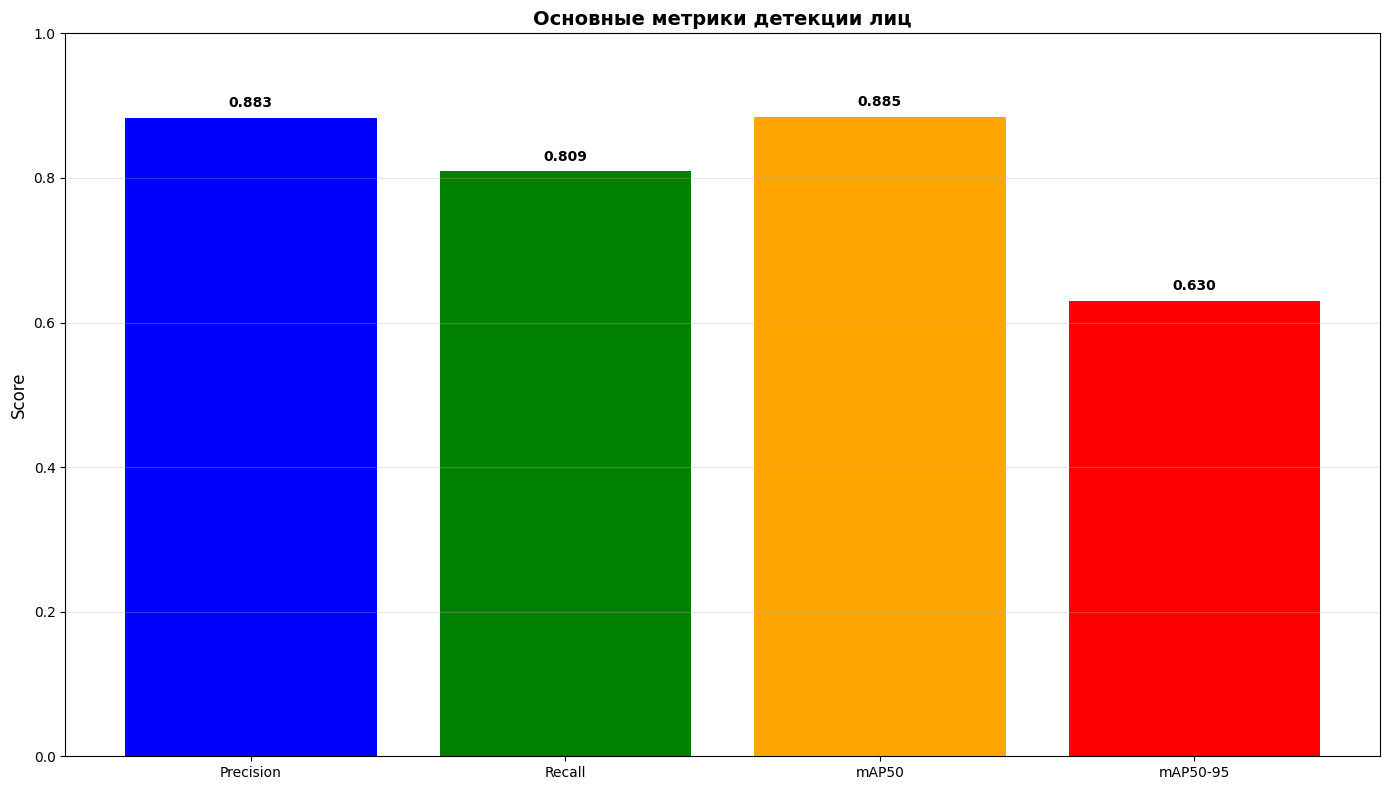

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


In [48]:
def simple_metrics_print(val_results):
    """
    Простая визуализация для детекции лиц с основными метриками и информацией о датасете
    """
    plt.figure(figsize=(14, 8))

    # Основные метрики
    plt.subplot(1, 1, 1)
    metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95']
    values = [val_results.box.mp, val_results.box.mr, val_results.box.map50, val_results.box.map]
    colors = ['blue', 'green', 'orange', 'red']

    bars = plt.bar(metrics, values, color=colors)
    plt.ylabel('Score', fontsize=12)
    plt.title('Основные метрики детекции лиц', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(True, axis='y', alpha=0.3)

    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')


    #plt.axis('on')

    plt.tight_layout()
    #plt.savefig('/content/runs/val/face_detection_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# Использование
simple_metrics_print(val_results)

#### Предсказания

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.

Found https://img.freepik.com/free-vector/hand-drawn-people-waving-illustrated_23-2149202067.jpg locally at hand-drawn-people-waving-illustrated_23-2149202067.jpg
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
image 1/1 /content/hand-drawn-people-waving-illustrated_23-2149202067.jpg: 448x640 4 Human faces, 29.1ms
Speed: 5.0ms preprocess, 29.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


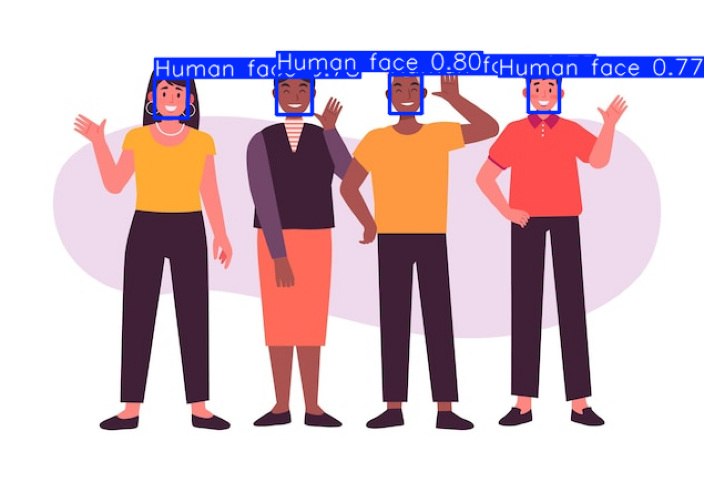

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.

Found https://st2.depositphotos.com/2927537/7025/i/450/depositphotos_70253417-stock-photo-funny-monkey-with-a-red.jpg locally at depositphotos_70253417-stock-photo-funny-monkey-with-a-red.jpg
image 1/1 /content/depositphotos_70253417-stock-photo-funny-monkey-with-a-red.jpg: 640x640 (no detections), 39.0ms
Speed: 4.0ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


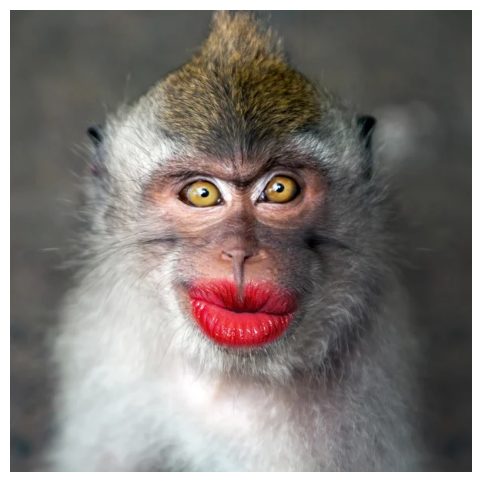

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.

Found https://rt-online.ru/uploads/old/uploads/2022/01/obezyana.jpg locally at obezyana.jpg
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
image 1/1 /content/obezyana.jpg: 448x640 1 Human face, 30.4ms
Speed: 6.6ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


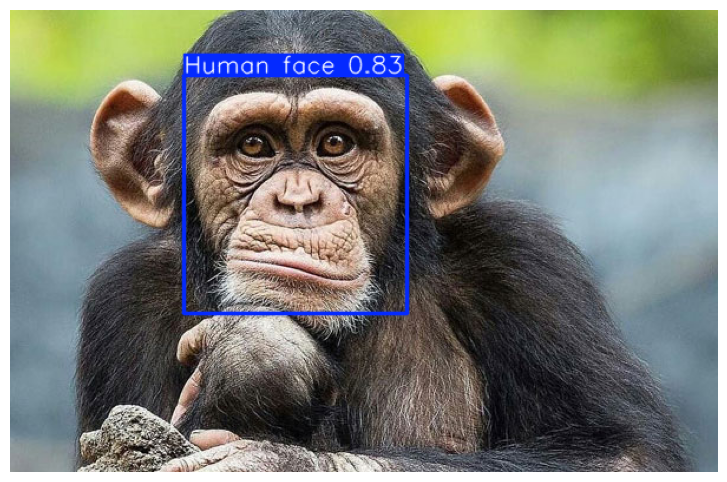


Found https://www.cbssev.ru/images/big5018.jpg locally at big5018.jpg
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
image 1/1 /content/big5018.jpg: 448x640 2 Human faces, 29.1ms
Speed: 3.3ms preprocess, 29.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera co

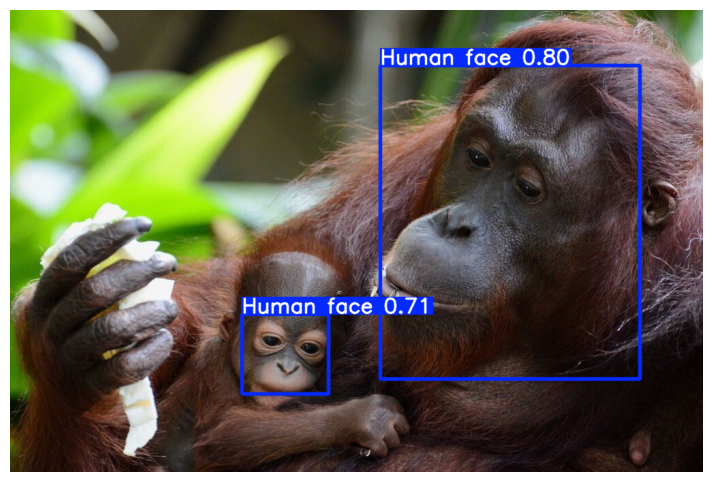


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP came

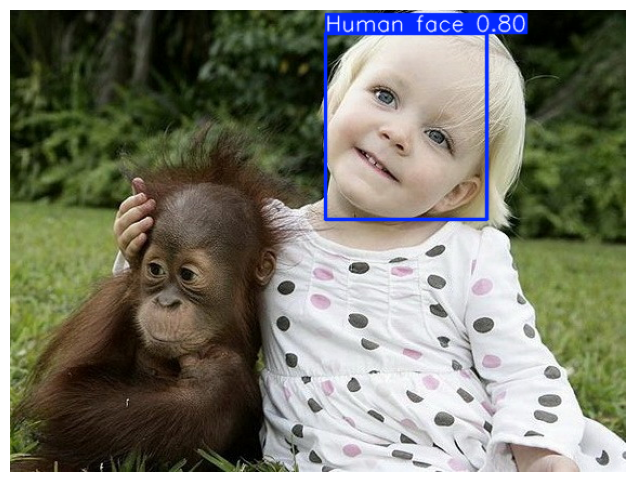

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


In [49]:
import cv2

url = "https://img.freepik.com/free-vector/hand-drawn-people-waving-illustrated_23-2149202067.jpg"
url1 = "https://st2.depositphotos.com/2927537/7025/i/450/depositphotos_70253417-stock-photo-funny-monkey-with-a-red.jpg"
url2 = "https://rt-online.ru/uploads/old/uploads/2022/01/obezyana.jpg"
url3 = "https://www.cbssev.ru/images/big5018.jpg"
url4 = "https://www.cbssev.ru/images/big2489.jpg"

image_list = [url, url1, url2, url3, url4]

# Инференс для каждого изображения
for url in image_list:
    pred_results = model.predict(url, conf=0.6)

    # Визуализация результатов
    for result in pred_results:
        img = result.plot()  # изображение с детекциями
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

In [ ]:
# Загрузка лучшей модели после обучения
best_model = YOLO('runs/train/exp1/weights/best.pt')

# Тестирование на одном изображении
result = best_model('test_image.jpg', save=True, conf=0.3)

# Получение feature maps (для анализа)
features = best_model.model.forward(torch.randn(1, 3, 640, 640).to(device))

In [ ]:
# После обучения сохраняем лучшие веса
best_model_path = '/content/best_face_detection.pt'
model.save(best_model_path)  # или используйте автоматическое сохранение из train()